In [89]:
from datetime import datetime
import pandas as pd
import os
import dateutil.parser as date_parser
import matplotlib.pyplot as plt
from typing import Any
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.arima import arima_string

## Load timeseries ticker data
### There are 3 tickers analysis is based on:
- S&P 500
- VIX - Volatility index
- US Treasury bonds

The analysis period is from 2000 to 2024

In [51]:
snp_path = os.path.join(os.getcwd(), 'assets', 's&p500_max.csv')
vix_path = os.path.join(os.getcwd(), 'assets', 'vix_max.csv')
us_treasury_bonds_path = os.path.join(os.getcwd(), 'assets', 'us_bonds_max.csv')

snp_data = pd.read_csv(snp_path, index_col='date', parse_dates=True)
vix_data = pd.read_csv(vix_path, index_col='date', parse_dates=True)
bonds_data = pd.read_csv(us_treasury_bonds_path, index_col='date', parse_dates=True)

start_date = '2000-01-01'
end_date = '2024-01-01'

snp_data = snp_data.loc[start_date:end_date]
vix_data = vix_data.loc[start_date:end_date]
bonds_data = bonds_data.loc[start_date:end_date]

# expected business days frequency. Input dataset might have some missing
frequency = 'B'
full_b_days = pd.date_range(start=snp_data.index.min(), end=snp_data.index.max(), freq=frequency)

# common_index = pd.DatetimeIndex(common_index, freq='B')

snp_data = snp_data.reindex(full_b_days)
vix_data = vix_data.reindex(full_b_days)
bonds_data = bonds_data.reindex(full_b_days)
snp_data['close'] = snp_data['close'].interpolate(method='linear')
vix_data['close'] = vix_data['close'].interpolate(method='linear')
bonds_data['close'] = bonds_data['close'].interpolate(method='linear')


missing_days = full_b_days.difference(snp_data.index)

assert len(missing_days) == 0

### S&P 500

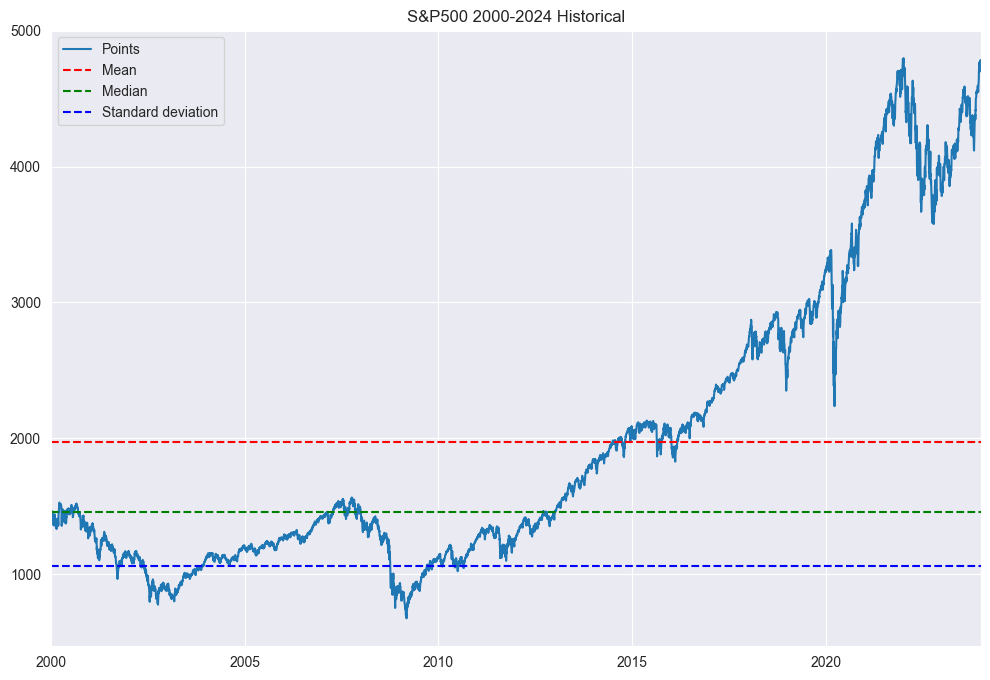

In [18]:
snp_plot = snp_data.plot(title='S&P500 2000-2024 Historical', y='close', label='Points', figsize=(12, 8))
snp_mean = snp_data['close'].mean()
snp_median = snp_data['close'].median()
snp_std = snp_data['close'].std()

snp_plot.axhline(y=snp_mean, label='Mean', color='r', linestyle='dashed')
snp_plot.axhline(y=snp_median, label='Median', color='g', linestyle='dashed')
snp_plot.axhline(y=snp_std, label='Standard deviation', color='b', linestyle='dashed')

snp_plot.legend()

### VIX

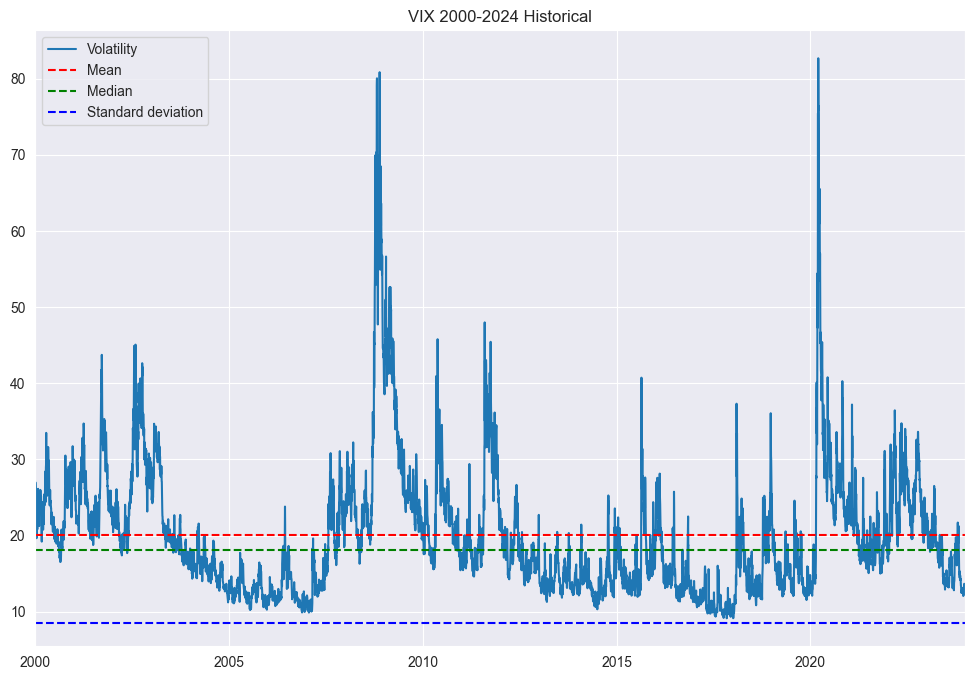

In [17]:
vix_plot = vix_data.plot(title='VIX 2000-2024 Historical', y='close', figsize=(12, 8), label='Volatility')

vix_mean = vix_data['close'].mean()
vix_median = vix_data['close'].median()
vix_std = vix_data['close'].std()

vix_plot.axhline(y=vix_mean, label='Mean', color='r', linestyle='dashed')
vix_plot.axhline(y=vix_median, label='Median', color='g', linestyle='dashed')
vix_plot.axhline(y=vix_std, label='Standard deviation', color='b', linestyle='dashed')

vix_plot.legend()

### US Bonds

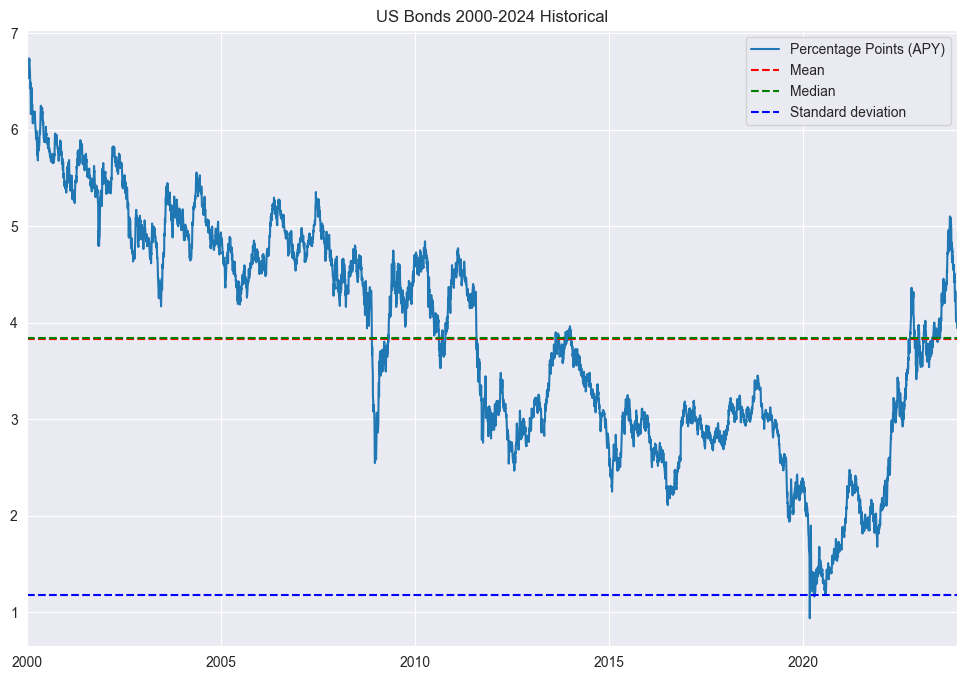

In [16]:
bonds_plot = bonds_data.plot(title='US Bonds 2000-2024 Historical', y='close',
                             label='Percentage Points (APY)', figsize=(12, 8))

bonds_mean = bonds_data['close'].mean()
bonds_median = bonds_data['close'].median()
bonds_std = bonds_data['close'].std()

bonds_plot.axhline(y=bonds_mean, label='Mean', color='r', linestyle='dashed')
bonds_plot.axhline(y=bonds_median, label='Median', color='g', linestyle='dashed')
bonds_plot.axhline(y=bonds_std, label='Standard deviation', color='b', linestyle='dashed')

bonds_plot.legend()

### Heatmap correlation matrix between S&P, VIX and US Bonds

Text(0.5, 1.0, 'Correlation matrix')

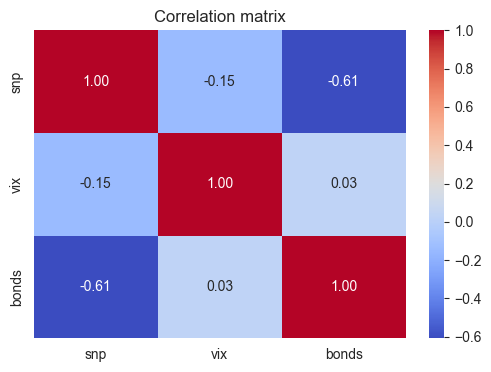

In [15]:
matrix_df = pd.DataFrame({
    'snp': snp_data['close'],
    'vix': vix_data['close'],
    'bonds': bonds_data['close']
})

corr_matrix_df = matrix_df.corr()

fig, ax = plt.subplots(figsize=(6, 4))

heatmap = sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
heatmap.set_title('Correlation matrix')

### Simple correlation between between S&P, VIX and US Bonds

Text(0.5, 1.0, 'Simple correlation')

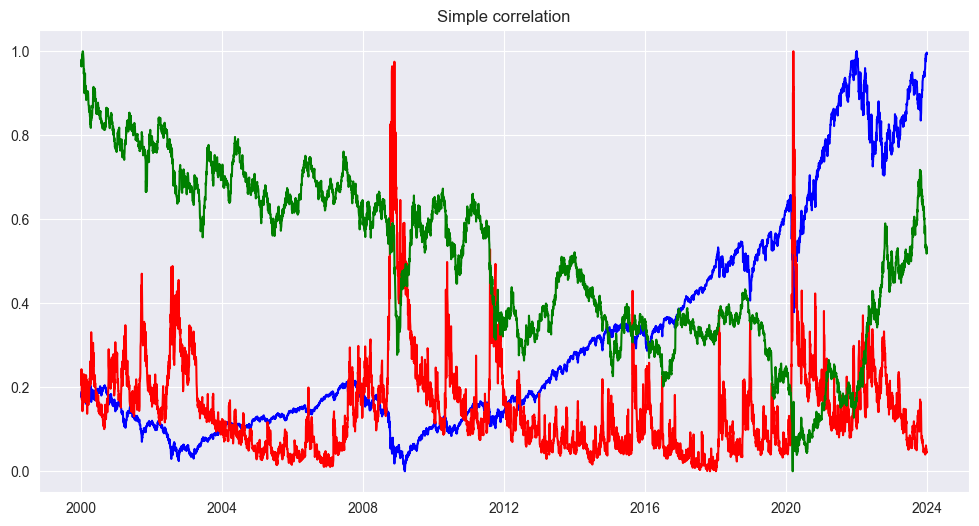

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

snp_norm = (snp_data['close'] - snp_data['close'].min()) / (snp_data['close'].max() - snp_data['close'].min())
vix_norm = (vix_data['close'] - vix_data['close'].min()) / (vix_data['close'].max() - vix_data['close'].min())
bonds_norm = (bonds_data['close'] - bonds_data['close'].min()) / (bonds_data['close'].max() - bonds_data['close'].min())

ax.plot(snp_norm.index, snp_norm, color='b')
ax.plot(vix_norm.index, vix_norm, color='r')
ax.plot(bonds_norm.index, bonds_norm, color='g')
ax.set_title('Simple correlation')

### Data model synthesis with numpy Gaussian Distribution
#### Characteristics used:
- Mean
- Median
- Std

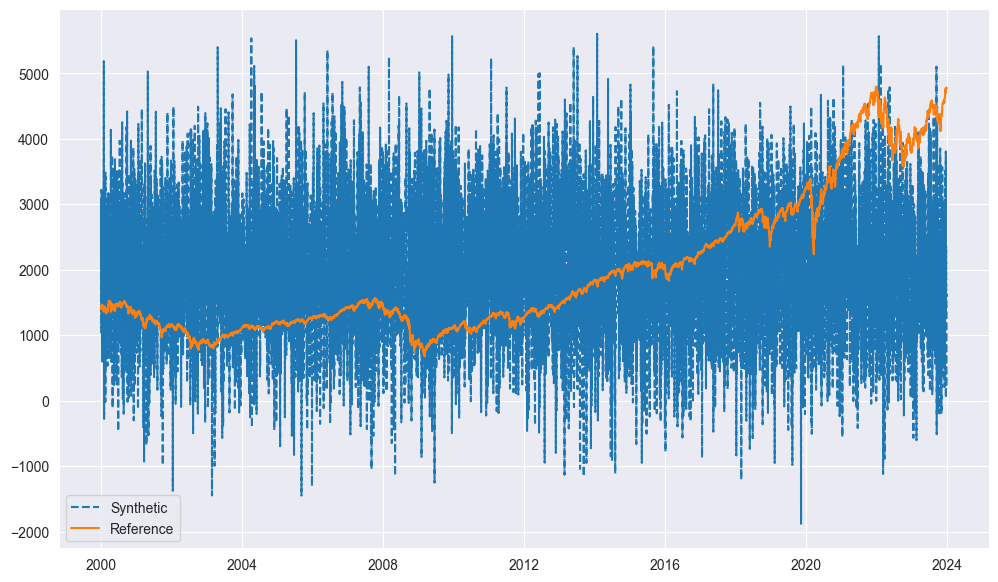

In [21]:
snp_synthetic = np.random.normal(loc=snp_mean, scale=snp_std, size=len(snp_data['close']))

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(snp_data.index, snp_synthetic, linestyle='--', label='Synthetic')
ax.plot(snp_data.index, snp_data['close'], label='Reference')
ax.legend()

### S&P 500 Decomposition

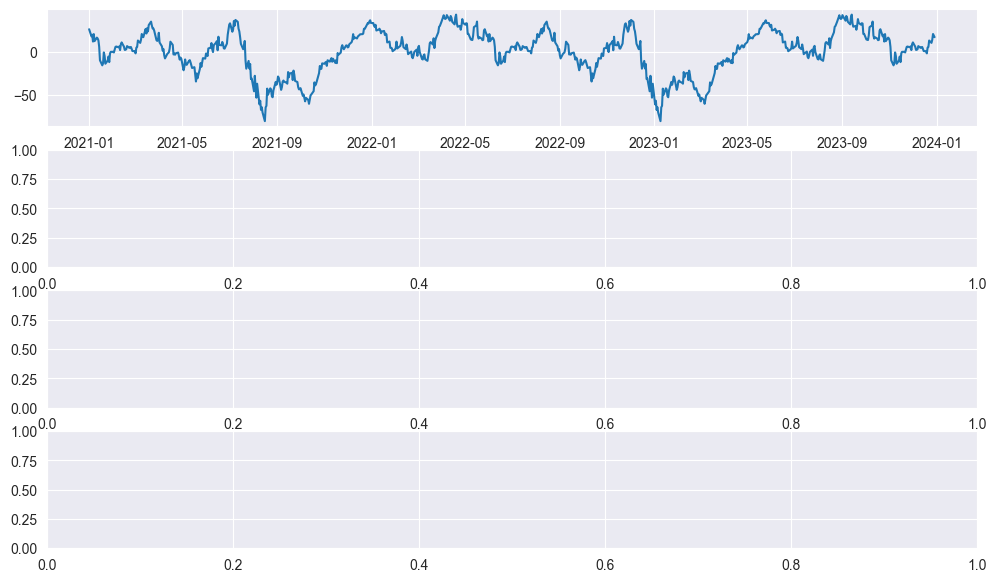

In [136]:
result = seasonal_decompose(snp_data['close'], model='additive', period=365)
fig, axs = plt.subplots(nrows=4, figsize=(12, 7))
start_date = '2021-01-01'
end_date = '2024-01-01'

axs[0].plot(result.seasonal[start_date:end_date], label='Seasonal')
# figure = result.plot()
# mean_seasonal_effect = result.seasonal.mean()
# print("Mean Seasonal Effect:", mean_seasonal_effect)

### Stationary test (Dicker-Fuller)
- Null Hypothesis - if true (a = 1), the series is stationary
- Alternate Hypothesis - if ture, the series is non-stationary

Test Statistic:  1.4781644817965207 {'1%': -3.4314005857922973, '5%': -2.862004265452834, '10%': -2.567017125598209}
p-value:  0.9974418475474329
Lags used:  32
Observations used:  6227


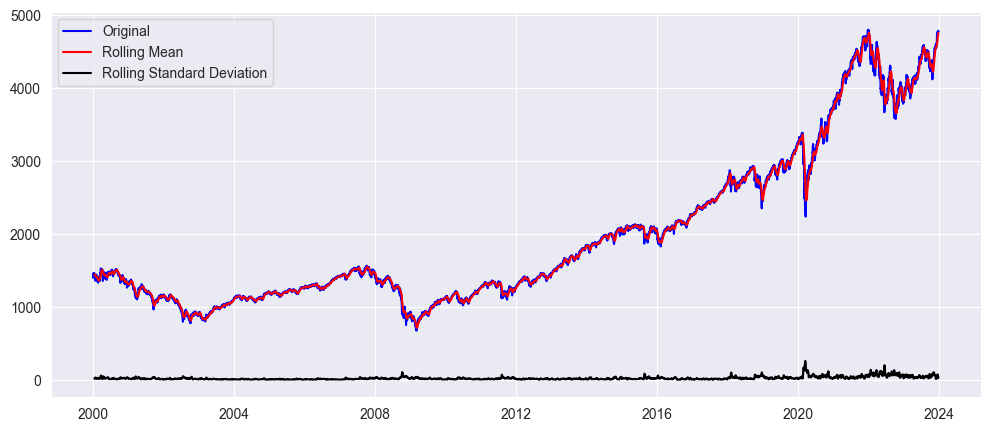

In [118]:
snp_rollmean = snp_data['close'].rolling(12).mean()
snp_rollstd = snp_data['close'].rolling(12).std()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(snp_data['close'], color='b', label='Original')
ax.plot(snp_rollmean, color='r', label='Rolling Mean')
ax.plot(snp_rollstd, color='black', label='Rolling Standard Deviation')
ax.legend()

# Augmented Dicker-Fuller Test
adft = adfuller(snp_data['close'], autolag='AIC')
print('Test Statistic: ', adft[0], adft[4])
# P-value tells us how likely the data would've appeared the way it did if null-hypothesis were true.
print('p-value: ', adft[1])
print('Lags used: ', adft[2])
print('Observations used: ', adft[3])

### Data model synthesis with ARIMA (Autoregressive Integrated Moving Average)

In [88]:
split_date = date_parser.parse(end_date) - relativedelta(years=1)
training_set = snp_data.loc[:split_date]
testing_set = snp_data.loc[split_date:]

training_df = pd.DataFrame({
    'close': training_set['close'],
    'ds': training_set.index,
    'unique_id': range(len(training_set['close']))
})
testing_df = pd.DataFrame({
    'close': testing_set['close'],
    'ds': testing_set.index,
    'unique_id': range(len(testing_set['close']))
})

arima_model = StatsForecast(
    models = [AutoARIMA()],
    freq=frequency,
    n_jobs=-1
)
# arima_model = ARIMA(order=(1, 1, 1), season_length=7)
# # 5 - AR term. Values will be used to predict the new one.
# # 1 - I term. Difference will be used (current - previous) to make the series stationary
# # 0 - MA term. 0 means do NOT include error differences from the previous values
arima_model = arima_model.fit(df=training_df, target_col='close', time_col='ds')
# arima_model = arima_model.fit(y=training_df['close'].values)
print(arima_string(arima_model.fitted_[0,0].model_))

# # Predict next year
steps = len(testing_set['close'])
# snp_synthetic = arima_model.forecast(y=training_df['close'].values, h=steps)
snp_synthetic = arima_model.forecast(steps=steps)


ARIMA(0,0,0) with zero mean    


TypeError: StatsForecast.forecast() got an unexpected keyword argument 'steps'

In [73]:
snp_synthetic

{'mean': array([3841.70116725, 3841.01681047, 3841.22958131, 3841.16342952,
        3841.18399653, 3841.17760211, 3841.17959018, 3841.17897208,
        3841.17916425, 3841.1791045 , 3841.17912308, 3841.1791173 ,
        3841.1791191 , 3841.17911854, 3841.17911871, 3841.17911866,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 3841.17911867, 3841.17911867,
        3841.17911867, 3841.17911867, 38

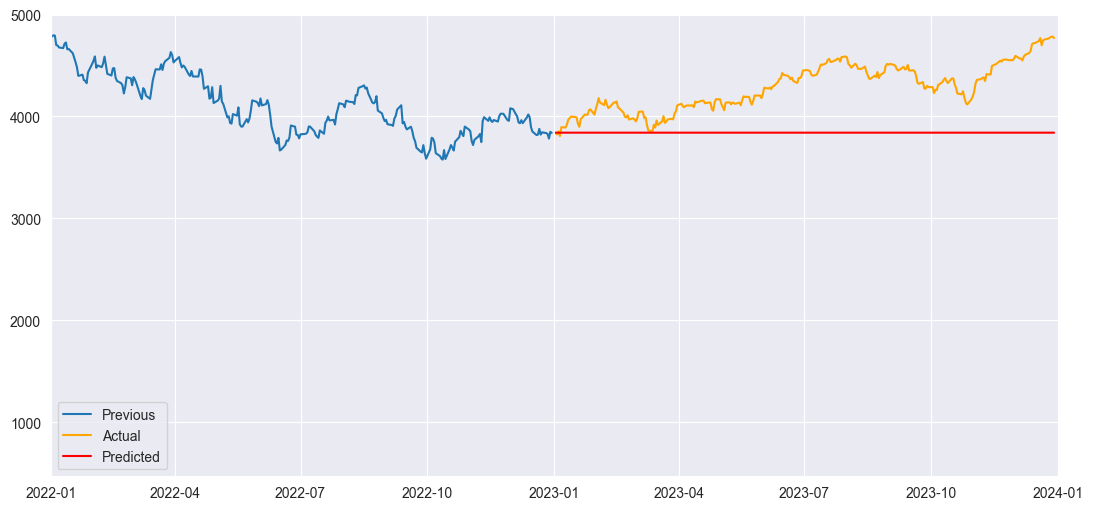

In [83]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.set_xlim(date_parser.parse('2022-01-01'), date_parser.parse('2024-01-01'))
ax.plot(training_set.index, training_set['close'], label='Previous')
ax.plot(testing_set.index, testing_set['close'], color='orange', label='Actual')
# ax.plot(testing_set.index[:steps], snp_synthetic.iloc[len(snp_synthetic['AutoARIMA']) - steps:]['AutoARIMA'], color='r', label='Predicted')
ax.plot(testing_set.index[:steps], snp_synthetic['mean'], color='r', label='Predicted')
# ax.fill_between(testing_set.index[:steps], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.2, label='Confidence Interval')

ax.legend()

In [87]:
residuals = arima_model.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.show()
print(arima_model.summary())

AttributeError: 'StatsForecast' object has no attribute 'resid'

In [546]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate errors
mae = mean_absolute_error(testing_set['close'], snp_synthetic.predicted_mean)
rmse = np.sqrt(mean_squared_error(testing_set['close'], snp_synthetic.predicted_mean))

print("MAE: ", mae)
print("RMSE: ", rmse)

MAE:  444.35124390890155
RMSE:  500.8533993183707
